In [56]:
from models import *
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
print("Tensorflow version: ", tf.__version__)

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
trained_models = ".\Trained models"

##Initiate parameters
ticker = 'mrk'
period = "1wk"

formation_window = 24
target_window = 4

sentiment = False
sentiment_type = 'RobertaLargeSentiment'  #APISentiment	VaderSentiment	CombinedVaderSentiment RobertaLargeSentiment

split_ratio = 0.80

#Do not change
if sentiment == False:
    news_df = None
    
#Do not change
window_size = formation_window + 1

#Print stuffs
print("window size: ",window_size)
print("formation_window: ",formation_window)
print("target_window: ",target_window)
print("chart period: ",period)

#training batches
batch_size_train = 16
batch_size_valid = 4

#Period model is trained and tested
start_date = '2020-01-01' #''2020-01-01   2015-01-01
end_date = '2022-09-10'  #'' 2022-08-17

# #Delete folders
# shutil.rmtree(excel_reports)
# shutil.rmtree(saved_models)
# shutil.rmtree(trained_models)

#Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
    os.mkdir("Trained models")
except:
    pass


Tensorflow version:  2.9.1
window size:  25
formation_window:  24
target_window:  4
chart period:  1wk


In [57]:
if sentiment == True:

    from sentiment import GetNews

    GetNewsAPI = GetNews()

    api_key = '631505e804ec58.42743136'

    GetNewsAPI.fit(ticker=ticker,start_date=start_date,end_date=end_date,n_news=1000,token=api_key,offset = 0,export_excel=True)
    news_df, json = GetNewsAPI.transform()
news_df

In [58]:
from transformers_preprocess import PullData

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date=start_date, 
            end_date=end_date, 
            interval=period, #1wk
            progress=False,
            condition=False,####################################
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path = excel_reports,
            listed_conditions = None,
            sentiment = sentiment,
            sentiment_type = sentiment_type,
            news_df=news_df)

data_prep = GetData.transform()

#Validation
if window_size != (formation_window + 1):
    raise Exception(f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")
data_prep.head()

initial shape:  (149, 6)
Output shape:  (2875, 9)
--------> PullData completed



,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,trades
0,2019-12-30 00:00:00,86.755722,87.919846,86.230919,87.070610,84.009224,79.525286,77.328642,1
1,2020-01-06 00:00:00,87.051529,87.538170,84.360687,85.429390,84.009224,79.525286,77.328642,1
2,2020-01-13 00:00:00,85.419846,87.843513,84.799622,86.803436,84.009224,79.525286,77.328642,1
3,2020-01-20 00:00:00,86.564888,86.803436,81.660301,82.041985,84.009224,79.525286,77.328642,1
4,2020-01-27 00:00:00,81.202293,84.122139,80.830154,81.526718,84.009224,79.525286,77.328642,1


In [59]:
####################################################################

from transformers_preprocess import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=window_size, shuffle=False, debug=False,
                  export_excel=True, excel_path=excel_reports,sentiment=sentiment)

data_normalized, Dates = NormalizeData.transform(data_prep)
data_normalized.head()
# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast



Dataframe shape:  (2875, 9)
Number of formations:  115
--------> NormalizeData completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,maxv,minv
0,0.954630,1.000000,0.934176,0.966902,0.847589,0.672834,0.587223,87.919846,62.261452
1,0.966159,0.985125,0.861287,0.902938,0.847589,0.672834,0.587223,87.919846,62.261452
2,0.902566,0.997025,0.878394,0.956490,0.847589,0.672834,0.587223,87.919846,62.261452
3,0.947192,0.956490,0.756043,0.770919,0.847589,0.672834,0.587223,87.919846,62.261452
4,0.738193,0.851990,0.723689,0.750837,0.847589,0.672834,0.587223,87.919846,62.261452


In [60]:
####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=True, excel_path=excel_reports,sentiment=sentiment)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)
#x_train.head(25)



Split ratio: 80 %
train period: 2019-12-30 - 2022-03-07
valid period: 2021-10-04 - 2022-08-15
x_train window:  92.0
x_valid window:  23.0
--------> SplitData completed



In [61]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



In [62]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)

# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



<b>Model Training</b>

In [63]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{sentiment}_{start_date}_{end_date}.h5'

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Get Model

In [64]:
tf.random.set_seed(7788)
np.random.seed(7788)

input_shape = x_train.shape[1]
print(f"Model training - {str.upper(ticker)} \n")

#model = clb_model(input_shape)
model = mrk_model(input_shape)

# model = tf.keras.models.Sequential([

#         tf.keras.layers.Conv1D(filters=8, kernel_size=1,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                input_shape=[None, input_shape]),
#         tf.keras.layers.Conv1D(filters=16, kernel_size=1,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                #input_shape=[None, 7]
#                                ),
#         tf.keras.layers.Conv1D(filters=32, kernel_size=10,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                #input_shape=[None, 7]
#                                ),

#         tf.keras.layers.Bidirectional(
#             tf.keras.layers.LSTM(9, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),

#         tf.keras.layers.Dense(4, activation=tf.nn.selu),
#         tf.keras.layers.Dense(4, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.relu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(1, activation=tf.nn.relu),
#     ])

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=8, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=1200, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Model training - MRK 

Epoch 1/1200
6/6 [==============================] - 11s 413ms/step - loss: 0.0356 - val_loss: 0.0296 - lr: 0.0050
Epoch 2/1200
6/6 [==============================] - 0s 36ms/step - loss: 0.0337 - val_loss: 0.0337 - lr: 0.0050
Epoch 3/1200
5/6 [========================>.....] - ETA: 0s - loss: 0.0305
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
6/6 [==============================] - 0s 37ms/step - loss: 0.0334 - val_loss: 0.0350 - lr: 0.0050
Epoch 4/1200
6/6 [==============================] - 0s 39ms/step - loss: 0.0320 - val_loss: 0.0348 - lr: 1.0000e-03
Epoch 5/1200
5/6 [========================>.....] - ETA: 0s - loss: 0.0298
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001999999862164259.
6/6 [==============================] - 0s 40ms/step - loss: 0.0319 - val_loss: 0.0346 - lr: 1.0000e-03
Epoch 6/1200
6/6 [==============================] - 0s 42ms/step - loss: 0.0316 - val_loss: 0.0345 - lr: 2.0000e-04
Epoch 7/1200
6/

In [65]:
# model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{start_date}_{end_date}.h5'
# model_name = 'Saved models\STNE_24_4_25_0.8_2020-01-01_2022-08-17.h5'
# model = tf.keras.models.load_model(model_name, custom_objects={
#                                              'sign_penalty': sign_penalty})


In [66]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


23/23 [==============================] - 2s 5ms/step


array([0.64699644, 0.6457373 ], dtype=float32)

In [67]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)

In [68]:
from transformers_preprocess import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=window_size, debug=False,
                         sentiment=sentiment,sentiment_type=sentiment_type)

df = ReverseNormalization.transform()
df.head(25)

--------> ReverseNormalization completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction
In,,,,,,,,,
0,84.169998,84.559998,80.150002,80.629997,77.635891,76.877429,76.284740,NaN,NaN
1,81.639999,81.639999,77.980003,78.330002,77.834209,77.100902,76.448361,NaN,NaN
2,78.739998,81.480003,77.110001,81.150002,78.781578,77.723840,76.824492,NaN,NaN
3,81.029999,88.459999,79.949997,88.050003,81.429699,79.312481,77.722533,NaN,NaN
4,88.050003,91.400002,81.349998,81.610001,81.481214,79.665945,78.033530,NaN,NaN
5,80.410004,84.260002,79.879997,84.000000,82.200867,80.332723,78.510848,NaN,NaN
6,84.150002,84.690002,80.620003,80.699997,81.772047,80.389227,78.685980,NaN,NaN
7,81.000000,83.589996,77.110001,79.160004,81.025749,80.200115,78.723902,NaN,NaN
8,76.419998,77.500000,72.660004,73.339996,78.829820,79.144713,78.293189,NaN,NaN


In [69]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid,
                      sentiment=sentiment,
                      sentiment_type=sentiment_type)

reversed_df = GetFinalDataframe.transform(df)
reversed_df.head(25)


--------> GetFinalDataframe



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime
In,,,,,,,,,,
0,84.169998,84.559998,80.150002,80.629997,77.635891,76.877429,76.284740,nn,nn,2021-10-04
1,81.639999,81.639999,77.980003,78.330002,77.834209,77.100902,76.448361,nn,nn,2021-10-11
2,78.739998,81.480003,77.110001,81.150002,78.781578,77.723840,76.824492,nn,nn,2021-10-18
3,81.029999,88.459999,79.949997,88.050003,81.429699,79.312481,77.722533,nn,nn,2021-10-25
4,88.050003,91.400002,81.349998,81.610001,81.481214,79.665945,78.033530,nn,nn,2021-11-01
5,80.410004,84.260002,79.879997,84.000000,82.200867,80.332723,78.510848,nn,nn,2021-11-08
6,84.150002,84.690002,80.620003,80.699997,81.772047,80.389227,78.685980,nn,nn,2021-11-15
7,81.000000,83.589996,77.110001,79.160004,81.025749,80.200115,78.723902,nn,nn,2021-11-22
8,76.419998,77.500000,72.660004,73.339996,78.829820,79.144713,78.293189,nn,nn,2021-11-29


In [72]:
from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=1,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)
trades_df.head(25)


ticker: MRK

Formations:  23
period: 2021-10-04 - 2022-08-15
Entry Candle:  Current Open

Total Trades:  13
Profit Trades:  12
Loss Trades:  1

Win Ratio: 92.0 %
Loss Ratio: 8 %

Trade nr with exact TP:  12
Ratio of exact TP: 92.0 %

Average profit per trade:  312

Gross profit:  4054
Gross loss:  -487

Net profit:  3567


,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
0,84.169998,84.559998,80.150002,80.629997,77.635891,76.877429,76.284740,nn,nn,2021-10-04,3.705232,1
1,81.639999,81.639999,77.980003,78.330002,77.834209,77.100902,76.448361,nn,nn,2021-10-11,3.705232,1
2,78.739998,81.480003,77.110001,81.150002,78.781578,77.723840,76.824492,nn,nn,2021-10-18,3.705232,1
3,81.029999,88.459999,79.949997,88.050003,81.429699,79.312481,77.722533,nn,nn,2021-10-25,3.705232,1
4,88.050003,91.400002,81.349998,81.610001,81.481214,79.665945,78.033530,nn,nn,2021-11-01,3.705232,1
5,80.410004,84.260002,79.879997,84.000000,82.200867,80.332723,78.510848,nn,nn,2021-11-08,3.705232,1
6,84.150002,84.690002,80.620003,80.699997,81.772047,80.389227,78.685980,nn,nn,2021-11-15,3.705232,1
7,81.000000,83.589996,77.110001,79.160004,81.025749,80.200115,78.723902,nn,nn,2021-11-22,3.705232,1
8,76.419998,77.500000,72.660004,73.339996,78.829820,79.144713,78.293189,nn,nn,2021-11-29,3.705232,1


In [73]:
trade = 13
budget = 10000
entry_candle = 'Current Open'
# loss = trades_df[trades_df['profit']<0]
# loss['trade'].unique()
# trades_df.loc[trades_df['trade']==12]


Trade:  13
Window size:  25
Period: 2022-03-07 - 2022-08-15

Budget:  10000

Entry price:  91.81
Label (target):  92.22
Model prediction:  92.7
Market Change: -4.47 $
Profit: -486.88 $


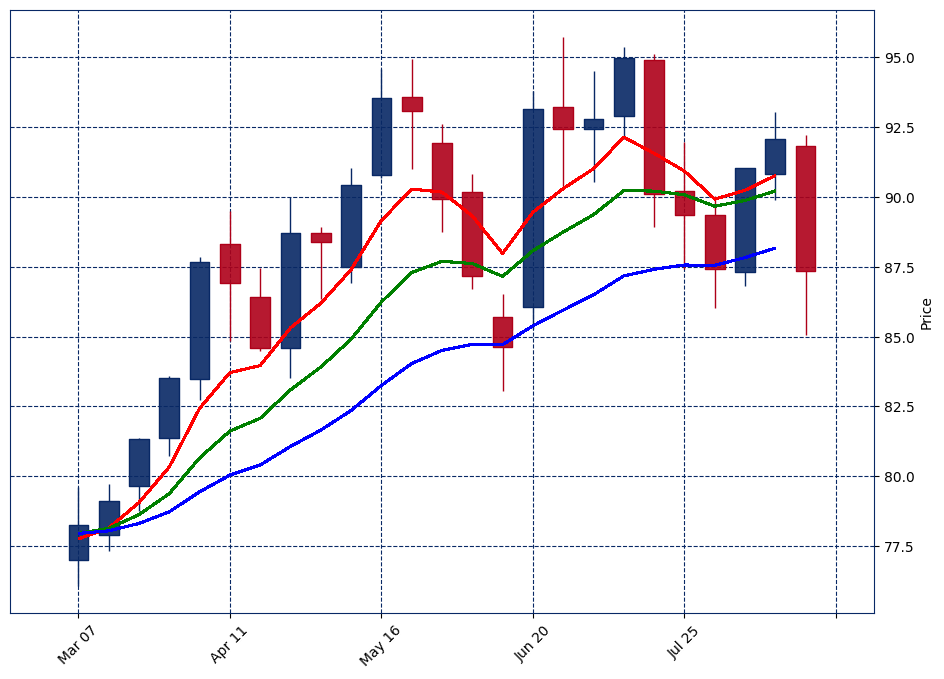

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
550,77.010002,79.629997,76.080002,78.260002,77.761538,77.957911,77.957138,nn,nn,2022-03-07,-4.470001,13
551,77.900002,79.739998,77.309998,79.110001,78.146813,78.135156,78.049367,nn,nn,2022-03-14,-4.470001,13
552,79.669998,81.379997,78.769997,81.339996,79.059151,78.628208,78.312618,nn,nn,2022-03-21,-4.470001,13
553,81.370003,83.580002,80.730003,83.519997,80.333678,79.380791,78.729208,nn,nn,2022-03-28,-4.470001,13
554,83.500000,87.839996,82.730003,87.680000,82.432627,80.657592,79.445271,nn,nn,2022-04-04,-4.470001,13
555,88.320000,89.480003,84.830002,86.910004,83.711878,81.619502,80.042450,nn,nn,2022-04-11,-4.470001,13
556,86.419998,87.449997,84.500000,84.589996,83.962769,82.076501,80.406254,nn,nn,2022-04-18,-4.470001,13
557,84.589996,90.010002,83.529999,88.690002,85.313407,83.093963,81.068953,nn,nn,2022-04-25,-4.470001,13
558,88.720001,88.919998,86.360001,88.389999,86.192433,83.908738,81.654637,nn,nn,2022-05-02,-4.470001,13


In [74]:
#trade = 1
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,budget=budget,sentiment=sentiment)
trade += 1
df


In [75]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade,Entry,Performance
0,84.169998,84.559998,80.150002,80.629997,77.635891,76.877429,76.284740,nn,nn,2021-10-04,3.705232,1,nn,nn
1,81.639999,81.639999,77.980003,78.330002,77.834209,77.100902,76.448361,nn,nn,2021-10-11,3.705232,1,nn,nn
2,78.739998,81.480003,77.110001,81.150002,78.781578,77.723840,76.824492,nn,nn,2021-10-18,3.705232,1,nn,nn
3,81.029999,88.459999,79.949997,88.050003,81.429699,79.312481,77.722533,nn,nn,2021-10-25,3.705232,1,nn,nn
4,88.050003,91.400002,81.349998,81.610001,81.481214,79.665945,78.033530,nn,nn,2021-11-01,3.705232,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,90.199997,91.949997,87.419998,89.339996,90.923700,90.073419,87.562040,nn,nn,2022-07-25,-4.470001,13,nn,nn
321,89.339996,90.019997,86.019997,87.410004,89.919787,89.663663,87.549877,nn,nn,2022-08-01,-4.470001,13,nn,nn
322,87.300003,91.029999,86.809998,91.019997,90.234132,89.872330,87.827487,nn,nn,2022-08-08,-4.470001,13,nn,nn
323,90.830002,93.019997,89.870003,92.080002,90.761524,90.211972,88.167688,nn,nn,2022-08-15,-4.470001,13,nn,nn


In [78]:
from final_evaluation import MakeSinglePrediction

model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{sentiment}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date="2021-03-18",
                        end_date="2022-09-09",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=1,
                        acceptance=0,
                        entry_candle='Current Close',
                        news_df=news_df,
                        sentiment=sentiment,
                        sentiment_type = sentiment_type)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.tail(24)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method
#final_trade_formation.fillna(0,inplace=True)
final_trade_formation


,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
54,2022-03-28,81.370003,83.580002,80.730003,83.519997,80.333678,79.380810,78.686010
55,2022-04-04,83.500000,87.839996,82.730003,87.680000,82.432628,80.657608,79.405529
56,2022-04-11,88.320000,89.480003,84.830002,86.910004,83.711878,81.619515,80.005887
57,2022-04-18,86.419998,87.449997,84.500000,84.589996,83.962769,82.076512,80.372616
58,2022-04-25,84.589996,90.010002,83.529999,88.690002,85.313407,83.093972,81.038007
59,2022-05-02,88.720001,88.919998,86.360001,88.389999,86.192433,83.908746,81.626166
60,2022-05-09,87.500000,91.050003,86.910004,90.410004,87.397453,84.908939,82.328873
61,2022-05-16,90.790001,94.559998,90.680000,93.550003,89.155325,86.238334,83.226564
62,2022-05-23,93.589996,94.919998,91.000000,93.080002,90.276661,87.290898,84.014839
63,2022-05-30,91.910004,92.620003,88.739998,89.910004,90.171902,87.693837,84.486452



Ticker:  mrk
1/1 [==============================] - 2s 2s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  87.42
Prediction:  91.87
Expected Market move:  4.45
Expected Profit:  507.26


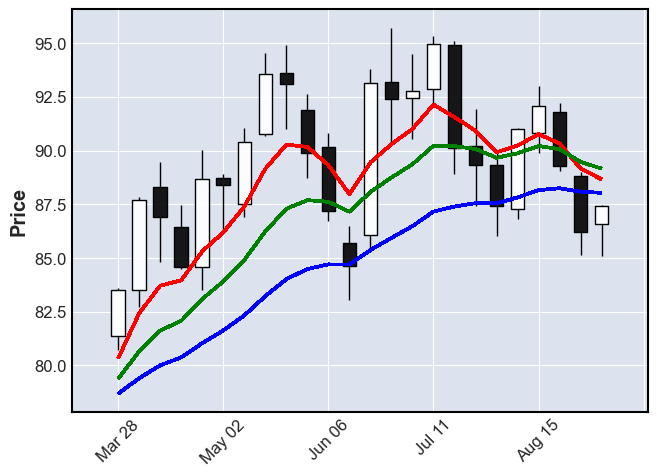

In [79]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart
from plotting import PlotCurrentFormation
PlotCurrentFormation(final_trade_formation)


<b>Record Predictions</b>

In [18]:
final_df = pd.DataFrame()
#List all predictions
dicti_prediction1 = {'ticker':['STNSE'],'Date':['21.8.2022'],'prediction':['12.97 (should be penalized by 2 - 10.97)'],'real market move':['pending']}
dicti_prediction2 = {'ticker':['CLB'],'Date':['21.8.2022'],'prediction':['18.6'],'real market move':['pending']}
dicti_prediction3 = {'ticker':['MRK'],'Date':['27.8.2022'],'prediction':['93.23'],'real market move':['pending']}
dicti_prediction4 = {'ticker':['CLB'],'Date':['04.9.2022'],'prediction':['18.08'],'real market move':['succesful - 9.9.2022']}

trades_tuple = (dicti_prediction1,dicti_prediction2,dicti_prediction3,dicti_prediction4)
for item in trades_tuple:
    df_pred = pd.DataFrame(item)
    final_df = final_df.append(df_pred)
final_df

,ticker,Date,prediction,real market move
0,STNSE,21.8.2022,12.97 (should be penalized by 2 - 10.97),pending
0,CLB,21.8.2022,18.6,pending
0,MRK,27.8.2022,93.23,pending
0,CLB,04.9.2022,18.08,succesful - 9.9.2022


In [12]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
a = sentiment_analysis("I love this!")



All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at siebert/sentiment-roberta-large-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[{'label': 'POSITIVE', 'score': 0.9988656044006348}]